# Imports

In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import numpy as np

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Load data

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

* 16
* 17
* 18
* 19


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

## ***Answer for Q1:==*** 19 

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?

* 32.59
* 42.59
* 52.59
* 62.59

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

## ***Answer for Q2:==*** 42.59

## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?
* 90%
* 92%
* 95%
* 98%

In [9]:
initial_size = len(df)
df = df[(df.duration >= 1) & (df.duration <= 60)]
cleaned_size = len(df)

In [10]:
fraction = cleaned_size/initial_size
initial_size, cleaned_size, initial_size - cleaned_size, f'{fraction:.2%}'

(3066766, 3009173, 57593, '98.12%')

## ***Answer for Q3:==*** 98%

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will 
  label encode them)
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

* 2
* 155
* 345
* 515
* 715

In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [12]:
df_categorial_descr = df[categorical].describe()
df_categorial_descr

,PULocationID,DOLocationID
count,3009173,3009173
unique,255,260
top,237,236
freq,147082,145424


In [13]:
df_categorial_descr.loc['unique'].sum()

515

## ***Answer for Q4:==*** 515

# One Hot Encoding with DictVectorizer

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
X_train.shape

(3009173, 516)

# Check correct encoding

In [16]:
train_dicts[:5]

[{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97},
 {'PULocationID': '43', 'DOLocationID': '237', 'trip_distance': 1.1},
 {'PULocationID': '48', 'DOLocationID': '238', 'trip_distance': 2.51},
 {'PULocationID': '138', 'DOLocationID': '7', 'trip_distance': 1.9},
 {'PULocationID': '107', 'DOLocationID': '79', 'trip_distance': 1.43}]

In [17]:
df[categorical + numerical].iloc[0]

PULocationID      161
DOLocationID      141
trip_distance    0.97
Name: 0, dtype: object

In [18]:
first_row = X_train[0,:].toarray()

nonzero_indices = np.nonzero(first_row)[1]
nonzero_indices

array([ 43, 325, 515])

In [19]:
feature_names = dv.get_feature_names_out()
feature_names[[43, 325, 515]]

array(['DOLocationID=141', 'PULocationID=161', 'trip_distance'],
      dtype=object)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 3.64
* 7.64
* 11.64
* 16.64

In [20]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.649143412761065

## ***Answer for Q5:==*** 7.64

/home/aleksandr/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aleksandr/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


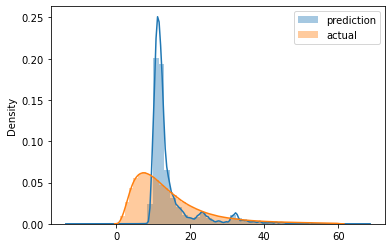

In [21]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [22]:
del df
del X_train

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023). 

What's the RMSE on validation?

* 3.81
* 7.81
* 11.81
* 16.81


# Preproc

In [23]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [24]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [25]:
len(df_train), len(df_val)

(3009173, 2855951)

In [26]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [28]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3009173, 516), (2855951, 516), (3009173,), (2855951,))

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.8114707302798605

## ***Answer for Q6:==*** 7.81

# Save model

In [30]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# Benchmark with other encoding and linear models

In [31]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.137900681701906

In [32]:
lr = Ridge(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.849078846535736

In [33]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [34]:
categorical = ['PU_DO']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3009173, 21802), (2855951, 21802), (3009173,), (2855951,))

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.198273785413548

In [37]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.395699095576239

In [38]:
lr = Ridge(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.766228439655007